In [220]:
import sys
sys.path.insert(0, "/home/spiffical/data/spiffical/")
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from StarNet.nn.utilities.data_augmentation import continuum_normalize, mask_tellurics, add_zeros, convolve_spectrum
from StarNet.gaiaESO.plotting import plot_compare_estimates_resid
from StarNet.nn.utilities.load_data import load_data_from_h5 
from keras.models import load_model

In [18]:
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True

In [15]:
def denormalize(data, norm_file):

    with open(norm_file,'r') as f1:
        mu = np.array(map(float, f1.readline().split()))
        sigma = np.array(map(float, f1.readline().split()))
    return ((data*sigma)+mu)

In [189]:
# Define all necessary paths
normalization_folder = 'data/normalization_files/' 

#model_path = 'Runs/StarNet_2018-10-31_run1/' + 'weights.best.h5'
model_path_4labels= 'Runs/StarNet_2019-03-05_run5/weights.best.h5'  # trained on 4 labels (teff, logg, [m/h], [a/m])
model_path_7labels = 'Runs/StarNet_2018-07-27_run1/model_weights.h5'  # trained on all 7 labels
model_path_5labels = 'Runs/StarNet_2019-03-08_run2/weights.best.h5'  # trained on 5 labels (teff, logg, [m/h], [a/m], v_rot)

norm_file_4labels = os.path.join(normalization_folder, 'mu_std_INTRIGOSS_UVES-4835-5395_vrad0_vrot0_training.txt')
norm_file_5labels = os.path.join(normalization_folder, 'mu_std_INTRIGOSS_UVES-4835-5395_vrad0_vrot70_training.txt')
norm_file_7labels = os.path.join(normalization_folder, 'mu_std_INTRIGOSS_gaiaeso_UVES-4835-5395_7labels.txt')

test_data_path = '/home/spiffical/data/spiffical/realspec/UVES/UVES_GE_MW_4835-5395_updated.h5'
data_folder_synth = '/spiffical/spectra/intrigoss/' 

# Define parameters to retrieve from the h5 data file
targets = ['teff', 'logg', 'M_H', 'a_M', 'v_rot', 'v_rad', 'VT']
spec_name = 'spectra_starnetnorm'

In [222]:
#data_file = data_folder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_testset.h5'
#data_file = data_folder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_noradialvel.h5'
data_file_0vrad_0vrot = data_folder_synth + 'INTRIGOSS_UVES-4835-5395_vrad0_vrot0_testing.h5'
data_file_0vrad_70vrot = data_folder_synth + 'INTRIGOSS_UVES-4835-5395_vrad0_vrot70_testing.h5'
data_file_200vrad_70vrot = data_folder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_testset.h5'

indices = np.arange(0,1500,1)

data = load_data_from_h5(data_file=data_file_0vrad_0vrot,
                         indices=indices,
                         targetname=targets,
                         specname=spec_name)
X_synth_0vrad_0vrot, y_synth_0vrad_0vrot, noise_synth_0vrad_0vrot, wave_grid = data.X, data.y, data.noise, data.wave_grid

data = load_data_from_h5(data_file=data_file_0vrad_70vrot,
                         indices=indices,
                         targetname=targets,
                         specname=spec_name)
X_synth_0vrad_70vrot, y_synth_0vrad_70vrot, noise_synth_0vrad_70vrot, wave_grid = data.X, data.y, data.noise, data.wave_grid

data = load_data_from_h5(data_file=data_file_200vrad_70vrot,
                         indices=indices,
                         targetname=targets,
                         specname=spec_name)
X_synth_200vrad_70vrot, y_synth_200vrad_70vrot, noise_synth_200vrad_70vrot = data.X, data.y, data.noise

# Mask telluric lines
#X_synth = mask_tellurics('telluric_lines.txt', X_synth, wave_grid)

# Zero-point bad values
X_synth_0vrad_0vrot[X_synth_0vrad_0vrot>1.03]=0
X_synth_0vrad_0vrot[X_synth_0vrad_0vrot<0] = 0
X_synth_0vrad_70vrot[X_synth_0vrad_70vrot>1.03]=0
X_synth_0vrad_70vrot[X_synth_0vrad_70vrot<0] = 0
X_synth_200vrad_70vrot[X_synth_200vrad_70vrot>1.03]=0
X_synth_200vrad_70vrot[X_synth_200vrad_70vrot<0] = 0

# Reshape data for compatibility with neural network
X_synth_0vrad_0vrot = np.reshape(X_synth_0vrad_0vrot, 
                                  (np.shape(X_synth_0vrad_0vrot)[0], 
                                   np.shape(X_synth_0vrad_0vrot)[1], 1))
X_synth_0vrad_70vrot = np.reshape(X_synth_0vrad_70vrot, 
                                  (np.shape(X_synth_0vrad_70vrot)[0], 
                                   np.shape(X_synth_0vrad_70vrot)[1], 1))
X_synth_200vrad_70vrot = np.reshape(X_synth_200vrad_70vrot, 
                                    (np.shape(X_synth_200vrad_70vrot)[0], 
                                     np.shape(X_synth_200vrad_70vrot)[1], 1))

In [201]:
# Load models
model_0vrad_0vrot = load_model(model_path_4labels)
model_0vrad_70vrot = load_model(model_path_5labels)
model_200vrad_70vrot = load_model(model_path_7labels)

In [209]:
# Predict on synthetic spectra
pred_train0vrad0vrot_test0vrad70vrot = model_0vrad_0vrot.predict(X_synth_0vrad_70vrot, batch_size=5, verbose=0)
pred_train0vrad70vrot_test0vrad70vrot = model_0vrad_70vrot.predict(X_synth_0vrad_70vrot, batch_size=5, verbose=0)
pred_train0vrad70vrot_test200vrad70vrot = model_0vrad_70vrot.predict(X_synth_200vrad_70vrot, batch_size=5, verbose=0)
pred_train200vrad70vrot_test200vrad70vrot = model_200vrad_70vrot.predict(X_synth_200vrad_70vrot, batch_size=5, verbose=0)

# Denormalize the predictions
pred_train0vrad0vrot_test0vrad70vrot = denormalize(pred_train0vrad0vrot_test0vrad70vrot, norm_file_4labels) 
pred_train0vrad70vrot_test0vrad70vrot = denormalize(pred_train0vrad70vrot_test0vrad70vrot, norm_file_5labels) 
pred_train0vrad70vrot_test200vrad70vrot = denormalize(pred_train0vrad70vrot_test200vrad70vrot, norm_file_5labels) 
pred_train200vrad70vrot_test200vrad70vrot = denormalize(pred_train200vrad70vrot_test200vrad70vrot, norm_file_7labels) 

In [217]:
columns = ['teff', 'logg', 'feh', 'am', 'delta teff', 'delta logg', 'delta feh', 'delta am', 'vrot']
truth = y_synth_0vrad_70vrot[:,:4]
vrot = np.expand_dims(y_synth_0vrad_70vrot[:,4], 1)  # expand dimensions so numpy concatenation works

pred = pred_train0vrad0vrot_test0vrad70vrot
data = np.concatenate((truth, pred - truth, vrot), axis=1)
df_train0vrad0vrot_test0vrad70vrot = pd.DataFrame(data, columns=columns)

pred = pred_train0vrad70vrot_test0vrad70vrot[:,:4]
data = np.concatenate((truth, pred - truth, vrot), axis=1)
df_train0vrad70vrot_test0vrad70vrot = pd.DataFrame(data, columns=columns)

concatenated = pd.concat([df_train0vrad0vrot_test0vrad70vrot.assign(dataset=r'$v_{rot}=$ 0km/s, $v_{rad}=0$km/s'), 
                          df_train0vrad70vrot_test0vrad70vrot.assign(dataset=r'$v_{rot}\leq 70$km/s, $v_{rad}=0$km/s')])

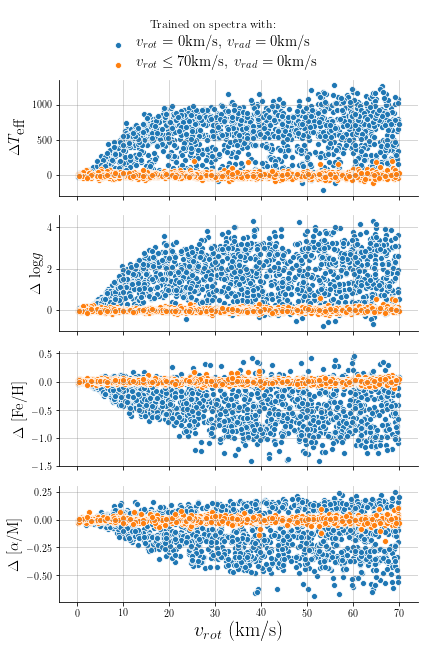

In [219]:
# Create the default pairplot
pp = sns.pairplot(concatenated, y_vars=['delta teff', 'delta logg', 'delta feh', 'delta am'],
                  x_vars=['vrot'], hue='dataset', height=2, aspect=3)

replacements = {'delta teff': r'$\Delta T_{\textrm{eff}}$', 'delta logg': '$\Delta$ log$g$',
                'delta feh': r'$\Delta$ [Fe/H]', 'delta am': r'$\Delta$ [$\alpha$/M]',
                'vrot': r'$v_{rot}$ (km/s)', 'dataset': 'Trained on spectra with:'}

# Change axis labels
for i in range(4):
    for j in range(1):
        xlabel = pp.axes[i][j].get_xlabel()
        ylabel = pp.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            pp.axes[i][j].set_xlabel(replacements[xlabel], size=20)
        if ylabel in replacements.keys():
            pp.axes[i][j].set_ylabel(replacements[ylabel], size=15)
            
# Change legend title
label = pp.fig.get_children()[-1].get_title().get_text()
if label in replacements.keys():
    pp.fig.get_children()[-1].get_title().set_text(replacements[label])
    pp.fig.get_children()[-1].get_title().set_fontsize(12)
    
pp.fig.get_children()[-1].set_bbox_to_anchor((0.55, 1.05, 0, 0))
    
# Change size of legend labels
for i in range(len(pp.fig.get_children()[-1].texts)):
    label = pp.fig.get_children()[-1].texts[i].get_text()
    pp.fig.get_children()[-1].texts[i].set_fontsize(15)


In [212]:
# Define common variables 
columns = ['teff', 'logg', 'feh', 'am', 'delta teff', 'delta logg', 'delta feh', 'delta am', 'vrad']
truth = y_synth_200vrad_70vrot[:,:4]
vrad = np.expand_dims(y_synth_200vrad_70vrot[:,5], 1)  # expand dimensions so numpy concatenation works

# Make dataframes for both trained models
pred = pred_train0vrad70vrot_test200vrad70vrot[:,:4]
data = np.concatenate((truth, pred - truth, vrad), axis=1)
df_train0vrad70vrot_test200vrad70vrot = pd.DataFrame(data, columns=columns)

pred = pred_train200vrad70vrot_test200vrad70vrot[:,:4]
data = np.concatenate((truth, pred - truth, vrad), axis=1)
df_train200vrad70vrot_test200vrad70vrot = pd.DataFrame(data, columns=columns)

# Concatenate the dataframes for plotting
concatenated = pd.concat([df_train0vrad70vrot_test200vrad70vrot.assign(dataset=r'$v_{rot}\leq 70$ km/s, $v_{rad}=0$ km/s'), 
                          df_train200vrad70vrot_test200vrad70vrot.assign(dataset=r'$v_{rot}\leq 70$ km/s, $v_{rad}\leq200$ km/s')])

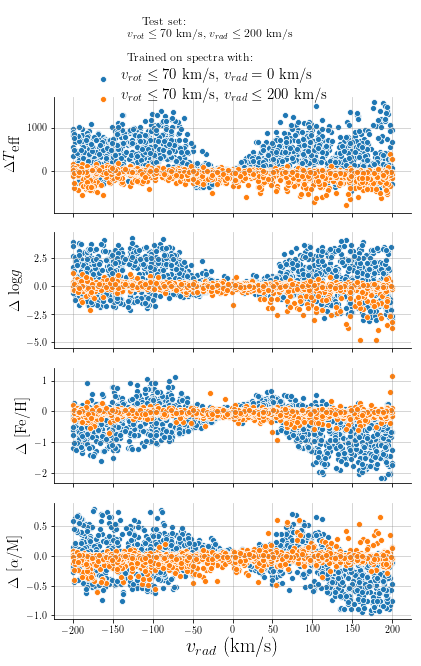

In [213]:
# Create the default pairplot
pp = sns.pairplot(concatenated, y_vars=['delta teff', 'delta logg', 'delta feh', 'delta am'],
                  x_vars=['vrad'], hue='dataset', height=2, aspect=3)

replacements = {'delta teff': r'$\Delta T_{\textrm{eff}}$', 'delta logg': '$\Delta$ log$g$',
                'delta feh': r'$\Delta$ [Fe/H]', 'delta am': r'$\Delta$ [$\alpha$/M]',
                'vrad': r'$v_{rad}$ (km/s)', 'dataset': r'Test set:\\$v_{rot}\leq 70$ km/s, $v_{rad}\leq200$ km/s\\ \\Trained on spectra with:'}

# Change axis labels
for i in range(4):
    for j in range(1):
        xlabel = pp.axes[i][j].get_xlabel()
        ylabel = pp.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            pp.axes[i][j].set_xlabel(replacements[xlabel], size=20)
        if ylabel in replacements.keys():
            pp.axes[i][j].set_ylabel(replacements[ylabel], size=15)
            
# Change legend title
label = pp.fig.get_children()[-1].get_title().get_text()
if label in replacements.keys():
    pp.fig.get_children()[-1].get_title().set_text(replacements[label])
    pp.fig.get_children()[-1].get_title().set_fontsize(12)
    
pp.fig.get_children()[-1].set_bbox_to_anchor((0.55, 1.05, 0, 0))
    
# Change size of legend labels
for i in range(len(pp.fig.get_children()[-1].texts)):
    label = pp.fig.get_children()[-1].texts[i].get_text()
    pp.fig.get_children()[-1].texts[i].set_fontsize(15)

## Let's see if the accuracy of predictions changes significantly with adding modifications

In [250]:
from pylab import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    
    setp(bp['boxes'][1], color='magenta', alpha=0.4)
    setp(bp['caps'][2], color='magenta', alpha=0.4)
    setp(bp['caps'][3], color='magenta', alpha=0.4)
    setp(bp['whiskers'][2], color='magenta', alpha=0.4)
    setp(bp['whiskers'][3], color='magenta', alpha=0.4)
    setp(bp['medians'][1], color='magenta', alpha=0.4)
    
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')
    
    # fill with colors
    colors = ['lightblue', 'pink']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

In [251]:
def make_boxplots(targets, SNR, difference, high_SNR, low_SNR, 
                  bin_centers, bin_width=[100,0.25], 
                  xlims=[0,22], ylims=[-250,250],
                  labels=[r'T$_{eff}$', r'log$g$', r'[M/H]'],
                  xlabel='',
                  ylabel=''):

    # Statistics
    bias = np.nanmedian(difference, axis=0)
    scatter = np.nanstd(difference, axis=0)
    
    numPlots = targets.shape[1]
    fig, axes = plt.subplots(numPlots, 1, figsize=(8, numPlots*1.5))
    
    for i in range(numPlots):
        bins = []
        for center in bin_centers[i]:
            inds1 = np.logical_and(abs(targets[:,i] - center) < bin_width[i], SNR>high_SNR) 
            inds2 = np.logical_and(abs(targets[:,i] - center) < bin_width[i], SNR<low_SNR)
            bins.append([difference[:,i][inds1],
                         difference[:,i][inds2]])
        

        for j in range(len(bins)):
            # Find the smallest bin, get number of elements in it so we can ensure every bin has
            # the same number of elements. Then plot each boxplot.
            min_bin = min([min(len(binnn[0]),len(binnn[1])) for binnn in bins])
            np.random.shuffle(bins[j][0])
            np.random.shuffle(bins[j][1])
            new_bins1 = bins[j][0][:min_bin]
            new_bins2 = bins[j][1][:min_bin]
            bp = axes[i].boxplot([new_bins1,new_bins2], showfliers=False,
                                 positions = [3*j+1.5,3*j+1.5], widths = [2.4,2.6],
                                 patch_artist=True,
                                 notch=True)
            setBoxColors(bp)
        
        # set axes limits and labels
        axes[i].set_xlim(xlims[i][0],xlims[i][1])
        axes[i].set_ylim(ylims[i][0],ylims[i][1])
        axes[i].set_xticklabels(centers[i])
        axes[i].set_xticks([j*3+1.5 for j in range(len(bins))])
        axes[i].axhline(y=0.0, color='black', linestyle='--', alpha=0.4)
        #axes[i].set_xlabel('ASPCAP', fontsize=12)
        #axes[i].set_ylabel('', fontsize=12)
        
        # Annotate median and std of residuals
        bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=1)
        axes[i].annotate(r'\textbf{{{}}}:  '.format(labels[i]) + '$\widetilde{{m}}=${0:6.2f}$;\ s =${1:6.2f}'.format(bias[i],scatter[i],width=6), 
                         xy=(0.05, 0.12), xycoords='axes fraction', fontsize=10, bbox=bbox_props)
        
        # annotate plots
        #bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=1)
        #annotation = labels[i]
        #axes[i].annotate(annotation, xy=(0.05, 0.12), xycoords='axes fraction', fontsize=9, bbox=bbox_props)
        
        axes[i].grid(False)

        # draw temporary red and blue lines and use them to create a legend
        hB, = axes[i].plot([0,0],'b-')
        hR, = axes[i].plot([0,0],'m-')
        if i != numPlots - 1:
            hB.set_visible(False)
            hR.set_visible(False)
    
    # Set x and y figure labels
    fig.text(0.02, 0.5, ylabel, ha='center', va='center', 
             rotation='vertical', fontsize=15)
    fig.text(0.5, 0.01, xlabel, ha='center', va='center',
             fontsize=15)
    
    # Set figure legend
    fig.legend((hB, hR), (r'S/N $>$ %s' % high_SNR, r'S/N $<$ %s' % low_SNR), 'upper center', ncol=2,
              framealpha=1.0)
    
    fig.subplots_adjust(wspace=.01, hspace=.3)
    fig.subplots_adjust(right=0.9, left=0.095, bottom=0.06, top=0.95)
    
    #fig.tight_layout()
    plt.show()

In [223]:
# Predict on synthetic spectra
pred_train0vrad0vrot_test0vrad0vrot = model_0vrad_0vrot.predict(X_synth_0vrad_0vrot, batch_size=5, verbose=0)
pred_train0vrad70vrot_test0vrad0vrot = model_0vrad_70vrot.predict(X_synth_0vrad_0vrot, batch_size=5, verbose=0)
pred_train200vrad70vrot_test0vrad0vrot = model_200vrad_70vrot.predict(X_synth_0vrad_0vrot, batch_size=5, verbose=0)

# Denormalize the predictions
pred_train0vrad0vrot_test0vrad0vrot = denormalize(pred_train0vrad0vrot_test0vrad0vrot, norm_file_4labels) 
pred_train0vrad70vrot_test0vrad0vrot = denormalize(pred_train0vrad70vrot_test0vrad0vrot, norm_file_5labels) 
pred_train200vrad70vrot_test0vrad0vrot = denormalize(pred_train200vrad70vrot_test0vrad0vrot, norm_file_7labels) 

In [255]:
# Define common variables for plotting
label_names = [r'$T_{\textbf{eff}}$',
               r'log$g$',
               r'[M/H]',
               r'[$\alpha$/M]']
centers = [np.arange(3750,7001,250), 
           np.arange(0.5, 5.01, 0.5),
           np.arange(-1.0, 0.51, 0.25),
           np.arange(-0.25, 0.51, 0.25)]
widths = [100, 0.1, 0.1, 0.1]
xlims=[[0,43], [0,30], [0,21], [0,12]]
ylims=[[-400,220], [-1.5,1], [-0.8,1.2], [-0.25,0.2]]
highsnr=150
lowsnr=100
targets = y_synth_0vrad_0vrot[:,:4]

#### Trained on 4 labels

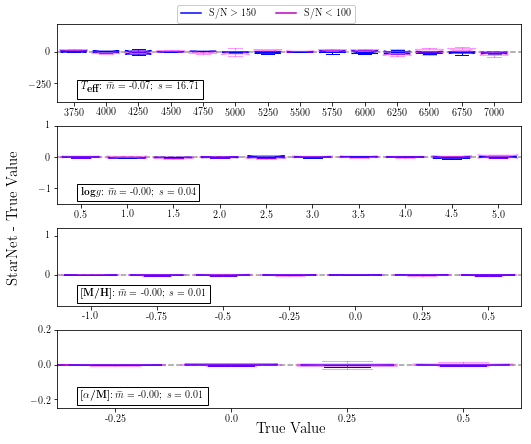

In [252]:
preds = pred_train0vrad0vrot_test0vrad0vrot[:,:4]
z = np.divide(1, noise_synth_0vrad_0vrot)
difference = preds - targets
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
make_boxplots(targets, 
              z, 
              difference, 
              highsnr, 
              lowsnr, 
              centers, widths, xlims, ylims,
              label_names,
              x_lab,
              y_lab)

#### Trained on 5 labels

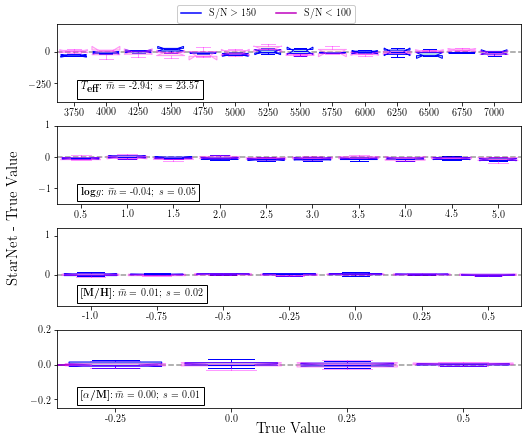

In [256]:
preds = pred_train0vrad70vrot_test0vrad0vrot[:,:4]
z = np.divide(1, noise_synth_0vrad_70vrot)
difference = preds - targets
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
make_boxplots(targets, 
              z, 
              difference, 
              highsnr, 
              lowsnr, 
              centers, widths, xlims, ylims,
              label_names,
              x_lab,
              y_lab)

#### Trained on 7 labels

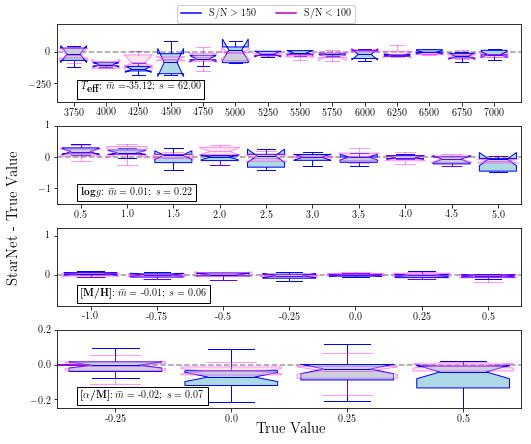

In [257]:
preds = pred_train200vrad70vrot_test0vrad0vrot[:,:4]
z = np.divide(1, noise_synth_200vrad_70vrot)
difference = preds - targets
x_lab=r'True Value'
y_lab=r'StarNet - True Value'
make_boxplots(targets, 
              z, 
              difference, 
              highsnr, 
              lowsnr, 
              centers, widths, xlims, ylims,
              label_names,
              x_lab,
              y_lab)

In [178]:
import h5py
import os

synthspec_folder = '/vmstorage/projects/gaiaeso/spectra/intrigoss/UVES_4835-5395/'
synthspec_filename = 'INTRIGOSS_UVES-4835-5395_vrad0_vrot70_training.h5'
synthspec_file = os.path.join(synthspec_folder, synthspec_filename)

def get_input_shape(data_file):
        
    # Load data file, pull out wave grid
    try:
        with h5py.File(data_file, 'r') as f:
            wav = f['wave_grid'][:]
    except IOError as error:
        print error
        print 'Data file either not declared or does not exist!'
    except KeyError as error:
        print error
        print 'h5 data file needs wavelength array stored in "wave_grid" key'

In [123]:
def get_input_shape(data_file):
        
    # Load data file, pull out wave grid
    with h5py.File(data_file, 'r') as f:
        wav = f['wave_grid5'][:]

In [129]:
get_input_shape(synthspec_file)